In [ ]:
import os

import tensorflow as tf
CONFIG = tf.ConfigProto(device_count = {'GPU': 1}, log_device_placement=False, allow_soft_placement=False)
CONFIG.gpu_options.allow_growth = True # Prevents tf from grabbing all gpu memory.
from collections import defaultdict
import pandas as pd
import matplotlib as plt
%matplotlib inline 
import supp_func
import importlib
importlib.reload(supp_func)

/home/yadongl1/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<module 'supp_func' from '/extra/yadongl10/DMVS/supp_func.py'>

In [4]:
def compute_Y_avg_var(Y):
    return np.mean( np.var(Y,axis=0) )
    

# Real data
# real_data_dir = '/extra/yadongl10/SVA/'
# data['Y'] = pd.read_table(real_data_dir+'combo_count_tab_simplified.txt',sep=' ')
# data['Y'] = np.sqrt(data['Y'])
# data['X'] = pd.read_table(real_data_dir+'udiet_adj_scale_117.txt',sep=' ')
# print(data['Y'].shape, data['X'].shape)
# print('real data avg variance',compute_Y_avg_var(data['Y']))

real_data_dir = '/extra/yadongl10/DMVS/'
data = {}
data['Y'] = pd.read_table(real_data_dir+'adj_taxacount.txt',sep='\t').iloc[:,1:]
data['X'] = pd.read_table(real_data_dir+'adj_nutri.txt',sep='\t').iloc[:,1:]
print(data['Y'].shape, data['X'].shape)
print('real data avg variance',compute_Y_avg_var(data['Y']))



(98, 30) (98, 117)
real data avg variance 58.558114674441185


# Training the model

In [6]:
def sigmoid(x):
     return 1 / (1 + np.exp(-x))
def hard_sigmoid(x):
    return np.minimum(np.maximum(x, np.zeros_like(x)), np.ones_like(x)) 


hp={'p':data['X'].shape[1],
    'q':data['Y'].shape[1],
    'K': 200,
    'zeta': 1.1,
    'gamma': -0.1,
    'gamma_zeta_logratio': np.log(0.1/1.1),
    'beta_p': 0.666
   }
print(hp)

K = hp['K']
p = hp['p']
q = hp['q']
zeta = hp['zeta']
gamma = hp['gamma']
gamma_zeta_logratio = hp['gamma_zeta_logratio']
beta_p = hp['beta_p']

tf.reset_default_graph()
tf.set_random_seed(1234)
mu_beta_0 = tf.get_variable("mu_beta_0", shape=[p,q], \
#                             initializer = tf.initializers.random_uniform(-1,1))
                            initializer=tf.contrib.layers.xavier_initializer()) 
mu_beta_1 = tf.get_variable("mu_beta_1", shape=[p,q], \
#                             initializer = tf.initializers.random_uniform(-1,1))
                            initializer=tf.contrib.layers.xavier_initializer())


alpha = tf.get_variable("alpha", shape=[p,q], initializer=tf.contrib.layers.xavier_initializer())
alpha_rep  = tf.stack([alpha]*K)
bias = tf.get_variable("bias", shape=[1,q], initializer=tf.contrib.layers.xavier_initializer()) 

x = tf.placeholder(tf.float32,[data['X'].shape[0],data['X'].shape[1]], name='data_x')
y = tf.placeholder(tf.float32,[data['Y'].shape[0],data['Y'].shape[1]], name='data_y')

###########################  define the mask (Bernoulli random variable)  
u = tf.random_uniform(shape=(K, p,q), minval=0, maxval=1,dtype=tf.float32)
s0 = tf.sigmoid( (tf.math.log(u) - tf.math.log(1 - u) + alpha_rep ) / beta_p )
s = s0 * (zeta - gamma) + gamma # stretch s
mask = tf.clip_by_value(s,0,1) # hard_sigmoid(s) shape=(K,p)
###########################
mu_beta = tf.where(tf.random_uniform([p]) - 0.5 < 0, mu_beta_0, mu_beta_1)
print( 'mu_beta shape is ', mu_beta.shape )
mu_beta_rep = tf.stack([mu_beta]*K)

noise = tf.random_normal(shape=(K, p,q), mean=0, stddev=1, dtype=tf.float32)
beta = tf.math.add(noise, mu_beta_rep)

masked_weights = tf.multiply(mask, beta)  # shape(K,p)
print('masked_weights/x shape',masked_weights.shape, x.shape)


activation = tf.reduce_mean(tf.tensordot(x, masked_weights, axes=[[1],[1]] ) , axis=1) + bias  
print('activation shape',activation.shape )
y_pred = tf.exp(activation)

print('y_pred shape', y_pred.shape)


class compute_loss:
    def __init__(self,  p=None, q=None,K=None):
        self.K  = K
        self.p  = p
        self.q  = q
        print('class')
    def NegDM_loglike(self,labels, y_pred):
        delta = y_pred # the first ouput corresponds to delta; 2nd corresponds to L0 penalty
        negloglike = -(tf.lgamma(labels+delta) - tf.lgamma(delta)) 
        negloglike = tf.reduce_sum(negloglike,axis=-1) \
        - ( tf.lgamma(tf.reduce_sum(delta,axis=-1)) - tf.lgamma(tf.reduce_sum(labels,axis=-1)+tf.reduce_sum(delta,axis=-1)) ) 
        negloglike = tf.reduce_sum(negloglike)
        print('neg shape',negloglike.shape )
        return negloglike

    def KL_welling(self, beta,mu_beta, alpha, noise, beta_p,gamma_zeta_logratio):
        log_qz = tf.reduce_sum( tf.math.log( tf.sigmoid(alpha - beta_p * gamma_zeta_logratio) ) ) 
        qz =   tf.reduce_sum( tf.sigmoid(alpha - beta_p * gamma_zeta_logratio)  )
        log_pz = tf.reduce_sum( tf.math.log(np.zeros([self.K, self.p, self.q], dtype=np.float32) + 0.5) ) / self.K
        KLD =  log_qz - log_pz + tf.reduce_sum(-0.5*tf.square(mu_beta)+tf.reduce_mean(tf.math.log(tf.square(beta)) ,axis=0)) # - log_pbeta + log_qbeta
        return qz, KLD 
    def KL_MC(self, beta,mu_beta, alpha, noise, beta_p,gamma_zeta_logratio):
        qz =    tf.sigmoid(alpha - beta_p * gamma_zeta_logratio)
        neg_entropy_q = tf.reduce_mean(tf.log(0.5/np.sqrt(2*np.pi)*tf.math.exp(-0.5*tf.square(beta-mu_beta_0)) \
                                            +0.5/np.sqrt(2*np.pi)*tf.math.exp(-0.5*tf.square(beta-mu_beta_1))) ,axis=0)
        KLD_tau_2 = tf.reduce_sum(qz*tf.log(qz/0.5) + (1-qz)*tf.log((1-qz)/0.5)) + \
                                tf.reduce_sum(qz*(neg_entropy_q + \
                                0.125*tf.square(mu_beta_0) + 0.125*tf.square(mu_beta_1) +\
                                np.log(np.sqrt(np.pi)) + 2*np.log(2)-\
                                tf.reduce_mean(tf.math.log(1*tf.square(beta) +1e-10) ,axis=0) ) ) 
        return KLD_tau_2, neg_entropy_q, qz 
    

    
################## compute the loss (objective)
compute = compute_loss(p=hp['p'], q=hp['q'],K=hp['K'])
Neglikelihood = compute.NegDM_loglike(y, y_pred)
KLD_tau_2, neg_entropy_q, qz = compute.KL_MC(beta,mu_beta, alpha, noise, beta_p,gamma_zeta_logratio)
loss = Neglikelihood + 1*KLD_tau_2
print('loss shape',Neglikelihood.shape,loss.shape)
##################

lr=tf.placeholder(tf.float32, name='learning_rate')
train_op1 = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss,var_list=[mu_beta_1, mu_beta_0, alpha, bias])


init = tf.global_variables_initializer()
costs_list = list()

sess = tf.Session()
sess.run(init)
import time
start_time = time.time()
for i in range(20000):
    _,cost,vKL,vNeglikelihood, valpha,vmu_beta, vneg_entropy_q, vqz, vbias, vact =sess.run([train_op1,
                                                                               loss,KLD_tau_2,
                                                                               Neglikelihood, 
                                                                               alpha,mu_beta,  
                                                                               neg_entropy_q, 
                                                                               qz,
                                                                               bias,
                                                                               activation],\
                                     feed_dict={x:data['X'],y:data['Y'],lr:0.01} ) #
    costs_list.append(cost)
    if i % 1000==0:
        s=sigmoid(valpha)*(zeta - gamma) + gamma
        print('epoch', i)
        print('beta',np.min(np.abs(vmu_beta)), np.max(np.abs(vmu_beta)),np.mean(np.abs(vmu_beta)) )
        print('bias',np.min(np.abs(vbias)), np.max(np.abs(vbias)),np.mean(np.abs(vbias)) )
        print('PPI',np.mean(s), np.max(s) ) 
        print('bacteriod', np.max(s[:,0]) )  
        print('loss, KL, Negloglike', cost, vKL, vNeglikelihood)
        print(' neg_entropy_q, qz', np.isnan(vneg_entropy_q).any(),  np.isnan(vqz).any(),\
              np.min(np.abs(vneg_entropy_q)),np.mean(np.abs(vqz)) )
elapsed_time = time.time() - start_time
print(elapsed_time)

{'p': 117, 'q': 30, 'K': 200, 'zeta': 1.1, 'gamma': -0.1, 'gamma_zeta_logratio': -2.3978952727983707, 'beta_p': 0.666}
mu_beta shape is  (117, 30)
masked_weights/x shape (200, 117, 30) (98, 117)
activation shape (98, 30)
y_pred shape (98, 30)
class
neg shape ()
loss shape () ()
epoch 0
beta 1.7434359e-05 0.20202641 0.10099757
bias 0.03330753 0.40261728 0.22672322
PPI 0.4974965 0.5632786
bacteriod 0.5578838
loss, KL, Negloglike 68035.22 7097.9717 60937.25
 neg_entropy_q, qz False False 1.2659826 0.83078814
epoch 1000
beta 5.821213e-05 1.4286004 0.26147392
bias 0.060835846 2.8761714 0.8983762
PPI -0.042355265 0.8165195
bacteriod 0.13969696
loss, KL, Negloglike 59132.902 2162.023 56970.88
 neg_entropy_q, qz False False 1.2667004 0.1809441
epoch 2000
beta 2.0190791e-05 1.8625141 0.4194004
bias 0.013792832 3.2870717 0.99346155
PPI -0.044859532 0.9851271
bacteriod 0.056351148
loss, KL, Negloglike 58720.52 2064.7314 56655.79
 neg_entropy_q, qz False False 1.2750058 0.16582644
epoch 3000
beta 

# Training stage statistics

We look into the loss function, a histogram of PPI and a plot showing the relation between PPI against threshold value. 

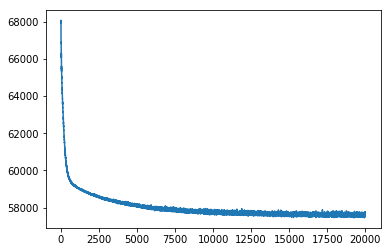

In [7]:
plt.plot(costs_list)

(array([305., 186.,  77.,  67.,  43.,  28.,  18.,  11.,  11.,   9.,  12.,
          5.,   5.,   4.,   4.,   2.,   5.,   2.,   3.,   1.,   3.,   2.,
          2.,   2.,   2.,   3.,   1.,   2.,   2.,   3.]),
 array([5.32716513e-06, 3.33384829e-02, 6.66716387e-02, 1.00004794e-01,
        1.33337950e-01, 1.66671106e-01, 2.00004262e-01, 2.33337417e-01,
        2.66670573e-01, 3.00003729e-01, 3.33336885e-01, 3.66670041e-01,
        4.00003196e-01, 4.33336352e-01, 4.66669508e-01, 5.00002664e-01,
        5.33335819e-01, 5.66668975e-01, 6.00002131e-01, 6.33335287e-01,
        6.66668442e-01, 7.00001598e-01, 7.33334754e-01, 7.66667910e-01,
        8.00001065e-01, 8.33334221e-01, 8.66667377e-01, 9.00000533e-01,
        9.33333688e-01, 9.66666844e-01, 1.00000000e+00]),
 <a list of 30 Patch objects>)

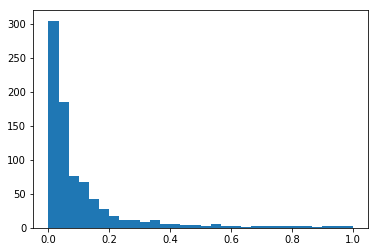

In [8]:
s=sigmoid(valpha)*(zeta - gamma) + gamma
s= hard_sigmoid(s).reshape(117*30)
s_non_zero = s[np.where(s>0.)[0]]
plt.hist( s_non_zero, bins=30 )



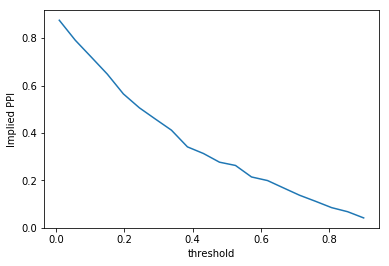

In [9]:
s=sigmoid(valpha)*(zeta - gamma) + gamma
s= hard_sigmoid(s).reshape(117*30)
def compute_implied_fdr(threshold, s):
    indicator = np.asarray( [s>threshold] )
    return np.sum( (1-s)*indicator ) / np.sum(indicator)
    
grid = np.linspace(0.01,0.9,20)
plt.plot( grid, [compute_implied_fdr(threshold_grid, s)  for threshold_grid in grid  ]  )
plt.xlabel('threshold')
plt.ylabel('Implied PPI')


# A look into what nutrients and taxa are selected

In [23]:
nutrients = list(data['X'])
real_data_dir = '/extra/yadongl10/SVA/'
data['Y'] = pd.read_table(real_data_dir+'combo_count_tab_simplified.txt',sep=' ')
taxa = list(data['Y'])
taxa = [taxa[i].split('.')[-1] for i in range(len(taxa))]


In [24]:
ffq_labels = pd.read_table('ffq_labels2.txt',sep=" ",skiprows=1)
nutrient_name = np.asarray(ffq_labels['Participant Identifier'])#
mean_beta_cl_real_data = np.abs(pd.read_csv('est_beta_cl_real_data_run2.txt', sep='\t').values[:, 2:])
def compute_implied_fdr(threshold, s):
    """
    Args:
        s: predicted probability
        threshold: level greater than threshold are selected

    Returns:
        fdr corresponding to the threshold
    """
    indicator = np.asarray([s > threshold])
    return np.sum((1 - s) * indicator) / np.sum(indicator)


def search_threshold(s, fdr):
    """
    Args:
        s: predicted probability
        fdr: controlled false discovery rate level

    Returns:
        largest threshold such that the fdr is less than the controlled level: fdr
    """
    for threshold in np.linspace(0, 1, 101):
        if compute_implied_fdr(threshold, s) < fdr:
            break
    return threshold

def compute_selected(s,print_rslt='False', method='VI'):
    loc = np.where(s>0)
    if method == 'VI':
        threshold = search_threshold(s, 0.1)
        loc = np.where(s>threshold)
    xy=[]
    strength=[]
    high_strength = {}
    pos_strength = {}
    for i in range(len(loc[0])):
        pos = [loc[0][i], loc[1][i]]
        nutrients_selected = str(nutrient_name[ffq_labels['id'] == str(nutrients[loc[0][i]]) ] )
        pos_strength[nutrients_selected+ '+' + str(taxa[loc[1][i]])] = s[loc[0][i], loc[1][i]] * vmu_beta[loc[0][i], loc[1][i]]
        xy.append(pos)
        strength.append(s[loc[0][i], loc[1][i]] )
        if s[loc[0][i], loc[1][i]] > 0.1:
            high_strength[str(nutrients[loc[0][i]]) + '+' + str(taxa[loc[1][i]])] = s[loc[0][i], loc[1][i]]
    if print_rslt == "True":
        for i in pos_strength.items():
            print(i)
    return loc,pos_strength

def compute_commom(loc_cl,loc_vi):
    common_list = []
    for i in range(len(loc_cl[0])):
        if loc_cl[0][i] in loc_vi[0]: # determin row is in 
            vi_index = np.where( loc_vi[0] == loc_cl[0][i] ) 
            if loc_cl[1][i] in loc_vi[1][vi_index]: # determine col is in | row is in
                nutrients_selected = str( nutrient_name[ ffq_labels['id'] == str(nutrients[loc_cl[0][i]]) ] )
                common_list.append(nutrients_selected + '+' + str(taxa[loc_cl[1][i]]))
    return common_list

def compute_one_dim_common(dim=0):
    common_list = []
    for i in range(len(loc_cl[dim])):
        if loc_cl[dim][i] in loc_vi[dim]:
            if dim == 0:
                nutrients_selected = str( nutrient_name[ ffq_labels['id'] == str(nutrients[loc_cl[0][i]]) ] )
                common_list.append(nutrients_selected)
            elif dim == 1:
                common_list.append(str(taxa[loc_cl[1][i]]))
    return common_list

loc_cl,_ = compute_selected(mean_beta_cl_real_data.T, method='chenli')
s=sigmoid(valpha)*(zeta - gamma) + gamma
loc_vi,pos_strength = compute_selected(s)
print( 'number of selected association', len(loc_vi[0]), len(loc_cl[0]))

common_item = compute_commom(loc_cl,loc_vi)
common_item_nutrient = compute_one_dim_common(dim=0)
common_item_taxa = compute_one_dim_common(dim=1)
print('common item','\n',common_item)
print( 'number of common association/nutrient/taxa', len(common_item), len(common_item_nutrient), len(common_item_taxa))

number of selected association 14 50
common item 
 ["['Maltose']+Prevotella"]
number of common association/nutrient/taxa 1 3 9


In [25]:
print( len(np.unique(loc_vi[0])), len(np.unique(loc_vi[1])))
print( len(np.unique(loc_cl[0])), len(np.unique(loc_cl[1])))

14 5
12 13


# Compute statistics

Now we take a look at the selected associations at controlled FDR of 0.1 and compare them with the associations selected association from Chenli's group lasso method. And we illustrate our results using a bipartite graph.

In [40]:
import numpy as np
import networkx as nx



class RealDataExp(object):
    def __init__(self, valpha, vmu_beta, data):
        self.beta = 2 / 3
        self.zeta = 1.1
        self.gamma = -0.1
        self.vmu_beta = vmu_beta
        self.pred = hard_sigmoid(sigmoid(valpha) * (self.zeta - self.gamma) + self.gamma)
        threshold = search_threshold(self.pred, 0.10)
#         threshold = 0.5
        print('threshold', threshold)
        
        self.s = np.zeros_like(self.pred)
        self.s[self.pred < threshold] = 0
        self.s[self.pred > threshold] = 1

        self.nutrients = list(data['X'])  # short abbrevation of nutrients
        Y = pd.read_table('/extra/yadongl10/SVA/combo_count_tab_simplified.txt',sep=' ')
        self.taxa = list(Y)
        self.taxa = [self.taxa[i].split('.')[-1] for i in range(len(self.taxa))]
        self.ffq_labels = pd.read_table('ffq_labels2.txt', sep=" ",
                                        skiprows=1)  # map from nutrients abbrevation to full name
        self.nutrient_name = np.asarray(self.ffq_labels['Participant Identifier'])  # nutrients full name
    
    def compute_s_pred(self):
        return self.pred, self.s
    
    def plot_selected(self):
        print('selected association pattern (above plot)--DMVI')
        supp_func.plot_data(self.s)
        

    def compute_selected(self, s, print_rslt='False', chenli=False):
        loc = np.where(s > 0)
        xy = []
        strength = []
        high_strength = {}
        pos_strength = {}
        for i in range(len(loc[0])):
            pos = [loc[0][i], loc[1][i]]
            nutrients_selected = str(self.nutrient_name[self.ffq_labels['id'] == str(self.nutrients[loc[0][i]])])
            pos_strength[nutrients_selected + '+' + str(self.taxa[loc[1][i]])] = self.pred[loc[0][i], loc[1][i]] * \
                                                                                 self.vmu_beta[
                                                                                     loc[0][i], loc[1][i]]
            if chenli == True:
                pos_strength[nutrients_selected + '+' + str(self.taxa[loc[1][i]])] = s[loc[0][i], loc[1][i]]
            xy.append(pos)
        if print_rslt == "True":
            for i in pos_strength.items():
                print(i)
        return loc, pos_strength

    def get_nutri_taxa_list(self, s):
        nutrient_list = []
        taxa_list = []
        loc = np.where(np.abs(s) > 0)
        for i in range(len(loc[0])):
            nutrient_list.append(self.nutrient_name[self.ffq_labels['id'] == str(self.nutrients[loc[0][i]])])
            taxa_list.append(self.taxa[loc[1][i]])

        nutrient_list = np.unique(nutrient_list).tolist()
        taxa_list = np.unique(taxa_list).tolist()
        return nutrient_list, taxa_list

    def draw_bipartite_graph(self,s, nutrient_list, taxa_list, chenli=False):
        G = nx.Graph()
        pos = nx.circular_layout(G)  # positions for all nodes
        loc = np.where(np.abs(s) > 0)
        plt.figure(figsize=(65, 50))
        # draw nodes
        G.add_nodes_from(nutrient_list)
        G.add_nodes_from(taxa_list)
        pos = nx.circular_layout(G)
        nx.draw_networkx_nodes(G, pos,
                               nodelist=nutrient_list,
                               node_color='green',
                               node_size=7500,
                               alpha=0.8)
        nx.draw_networkx_nodes(G, pos,
                               nodelist=taxa_list,
                               node_color='y',
                               node_shape='h',
                               node_size=7500,
                               alpha=0.8)

        for i in range(len(loc[0])):
            nutrients_selected = self.nutrient_name[self.ffq_labels['id'] == str(self.nutrients[loc[0][i]])]  # look up in the ffq_labels
            taxa_selected = [self.taxa[loc[1][i]]]
            # drasw edges
            strength =  self.pred[loc[0][i], loc[1][i]] * self.vmu_beta[loc[0][i], loc[1][i]] *3
            if chenli == True:
                strength = s[loc[0][i], loc[1][i]] *500
            
            if strength > 0:
                edge_col = 'r'
                edge_style = 'solid'
            else:
                edge_col = 'blue'
                edge_style = 'dashed'
            nx.draw_networkx_edges(G, pos,
                                   edgelist=[(nutrients_selected[0], taxa_selected[0])],
                                   width=np.abs(strength), alpha=0.5, edge_color=edge_col, style=edge_style)

        pos_higher = {}
        y_off = .05  # offset on the y axis
        for k, v in pos.items():
            pos_higher[k] = (v[0], v[1] + y_off)
            if k == 'Pyridoxine B6 w/o vit. pills' or k =='Pantothenic Acid w/o suppl.':
                print(v)
                pos_higher[k] = (v[0]+0.1, v[1] + y_off)
        nx.draw_networkx_labels(G, pos_higher, font_size=45, font_family='sans-serif')
        plt.axis('off')

        plt.show()
        return G


In [ ]:
RealDataExp = RealDataExp(valpha, vmu_beta, data)
RealDataExp.plot_selected()


# a look at selected nutrients and taxa

In [42]:
pred, s = RealDataExp.compute_s_pred()
loc, pos_strength = RealDataExp.compute_selected(s)
# mean_beta_cl_real_data = pd.read_csv('est_beta_cl_real_data_run2.txt', sep='\t').values[:, 2:]
# loc, pos_strength = RealDataExp.compute_selected(mean_beta_cl_real_data.T, chenli=True)
print(pos_strength)


{"['Calcium']+Barnesiella": -1.9940937, "['Zinc']+Sutterella": -2.4570951, "['Retinol']+Dialister": 2.0372648, "['Palmitoleic fatty acid']+Barnesiella": -2.1203058, "['Pyridoxine B6 w/o vit. pills']+Phascolarctobacterium": -2.3387778, "['Lycopene']+Prevotella": -1.9058034, "['Total Vitamin E, suppl. & fort. foods']+Dialister": -2.711767, "['Pantothenic Acid w/o suppl.']+Phascolarctobacterium": -2.3634586, "['Maltose']+Prevotella": 2.2566054, "['Glycemic Index']+Barnesiella": -2.4586105, "['Bran Scores']+Prevotella": -2.092687, "['Choline, Glycerophosphocholine']+Phascolarctobacterium": 1.9335222, "['Myricetin, flavonol']+Dialister": 2.1507807}


In [43]:
# nutrient_list, taxa_list = RealDataExp.get_nutri_taxa_list(mean_beta_cl_real_data.T)
nutrient_list, taxa_list = RealDataExp.get_nutri_taxa_list(s)

print(taxa_list)


['Barnesiella', 'Dialister', 'Phascolarctobacterium', 'Prevotella', 'Sutterella']


[-0.93969259  0.34202024]
[-9.99999969e-01 -5.93863706e-08]


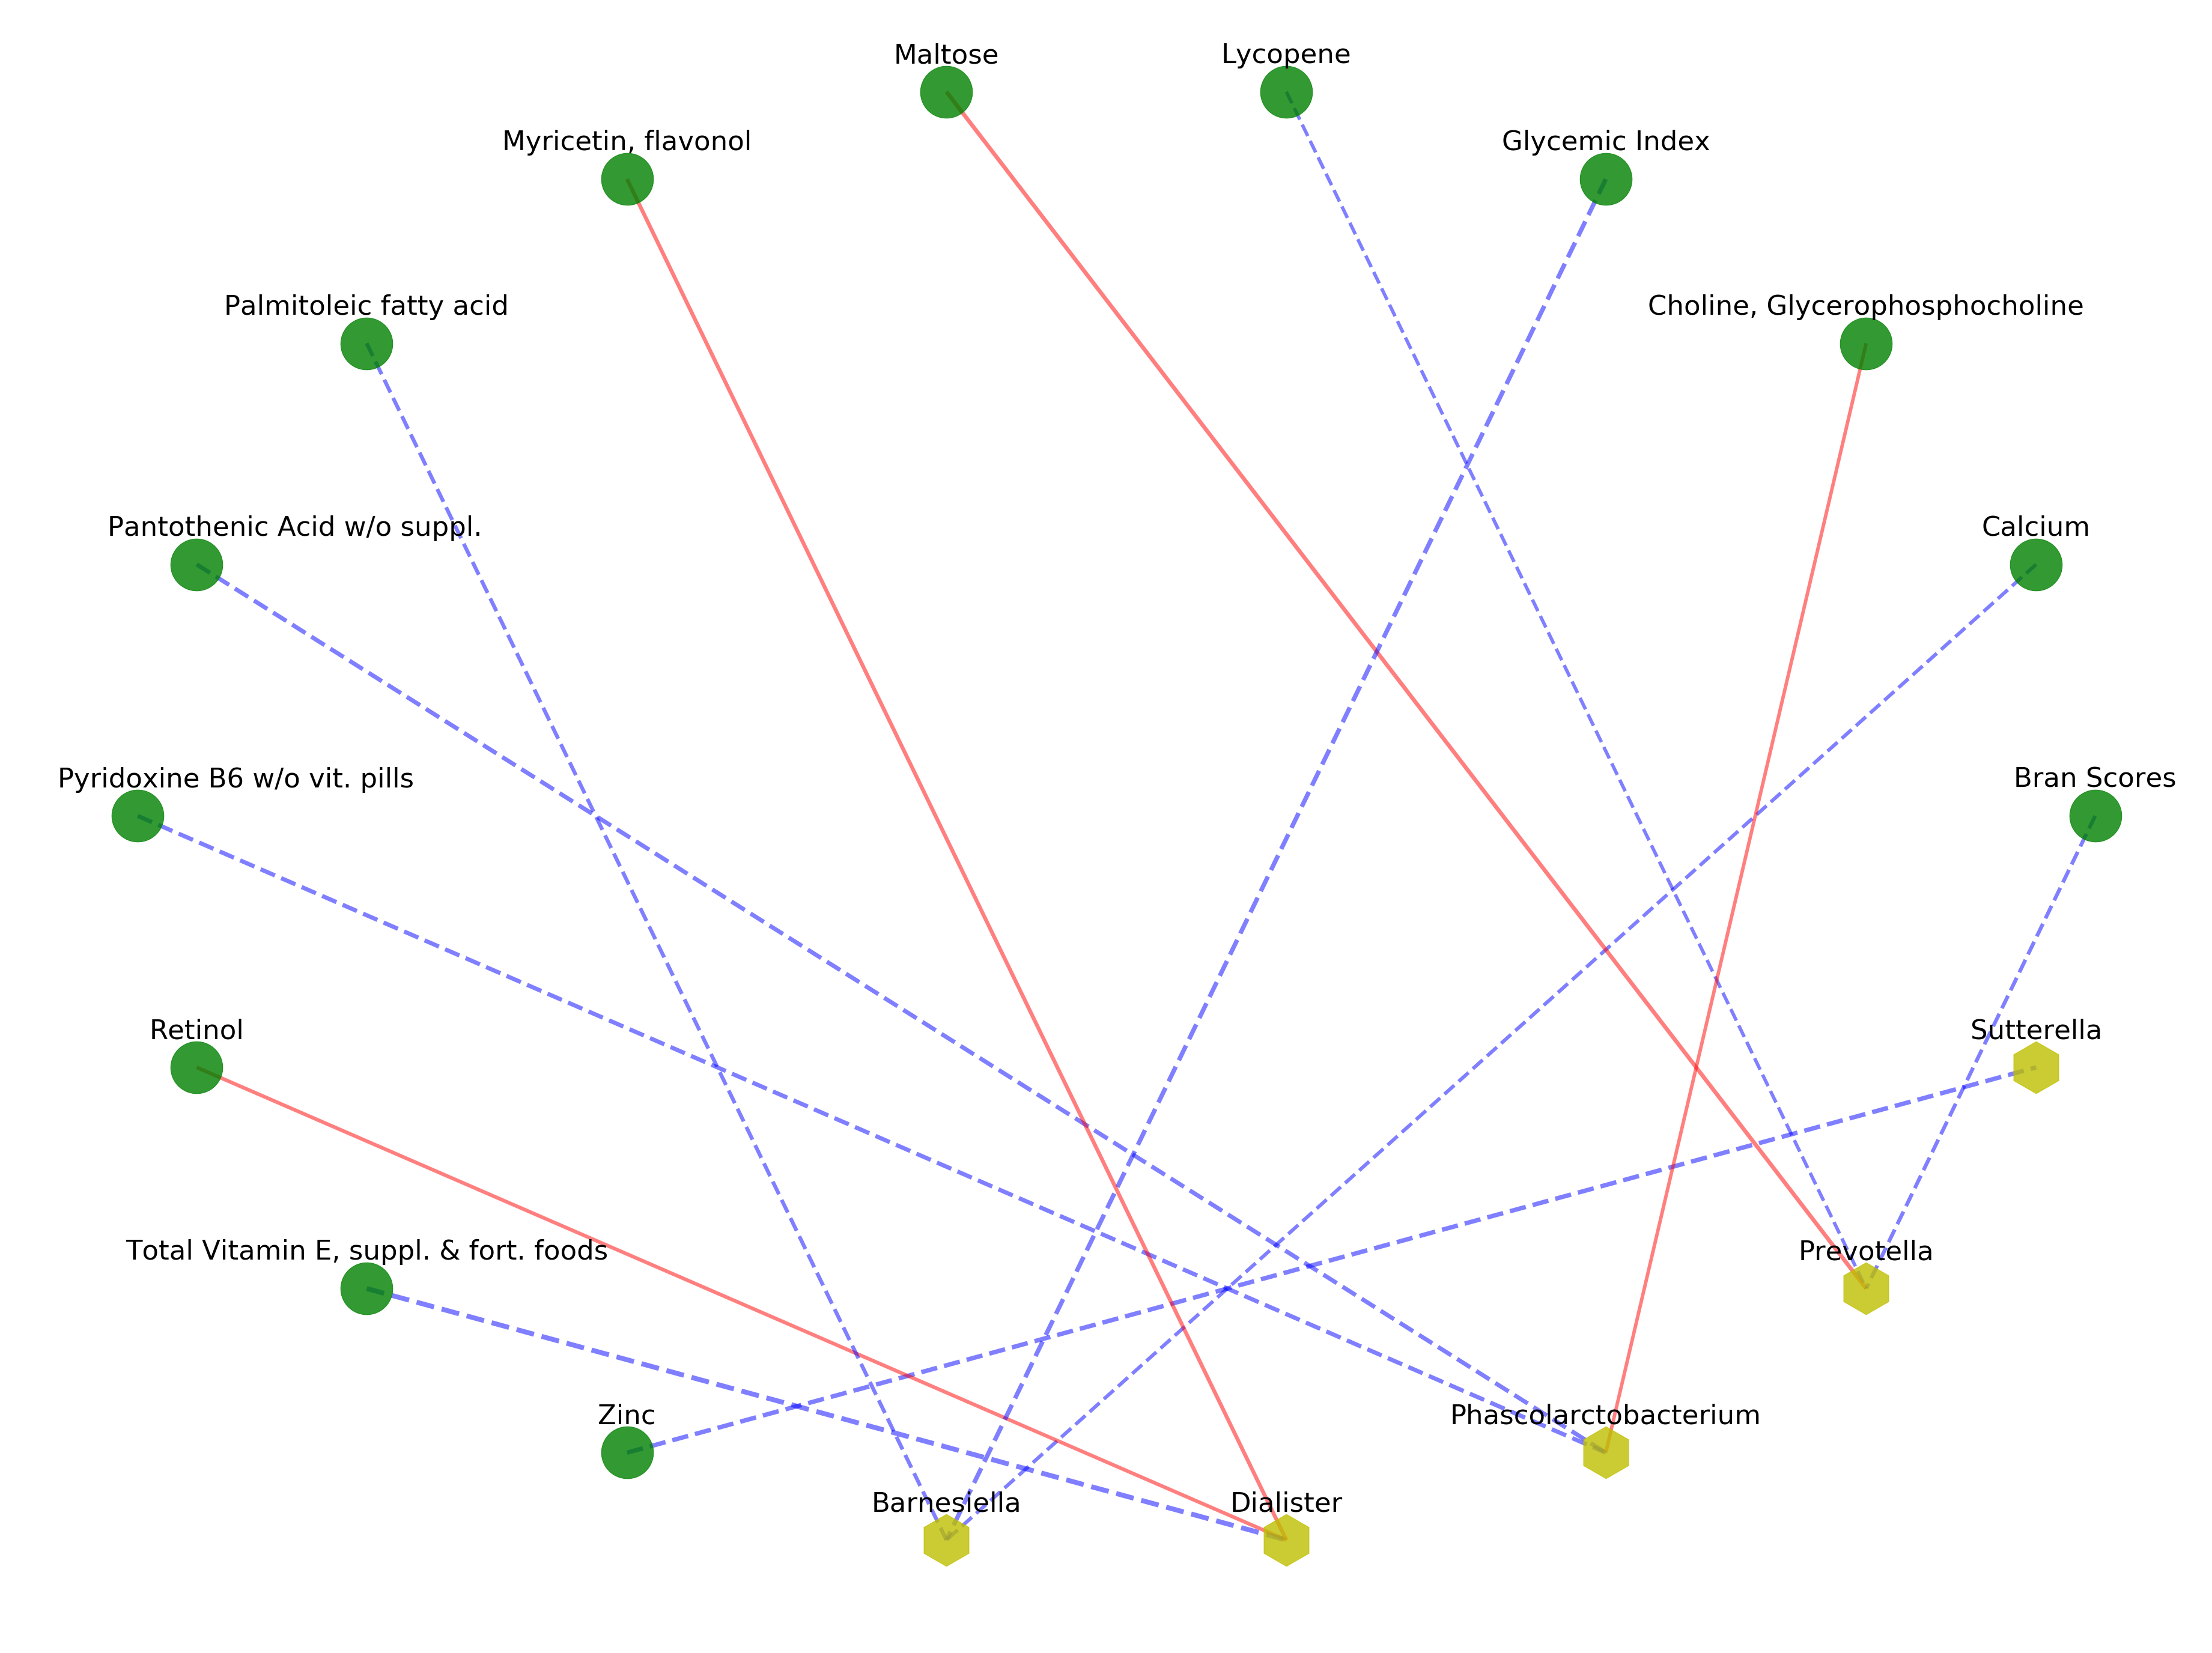

In [44]:
G = RealDataExp.draw_bipartite_graph(s, nutrient_list, taxa_list, chenli=False)
# s_chli = pd.read_csv('est_beta_cl_real_data.txt', sep='\t').values[:,2:]
# G = RealDataExp.draw_bipartite_graph(s_chli.T, nutrient_list, taxa_list, chenli=True)